In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir(f'/home/{user}/codes/MotionBERT')
import scipy.io

root_3dhp = f'/home/{user}/Datasets/HAAI/3DHP'
source = 'original' # 
root_original = os.path.join(root_3dhp, source)
train_folder = os.path.join(root_original, 'train')
test_folder = os.path.join(root_original, 'test')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# data_dict = {}

# # get train data
# for subject in tqdm(natsorted(os.listdir(train_folder))):
#     for seq in natsorted(os.listdir(os.path.join(train_folder, subject))):
#         #print(subject, seq)
#         data = scipy.io.loadmat(os.path.join(train_folder, subject, seq, 'annot.mat'))
#         #print(data.keys())
        
#         for cam_num in range(14):
#             source = '_'.join([subject, seq, f'cam{cam_num}'])
#             data_dict[source] = {}
#             anoot2 = mpi_inf_3dhp2h36m(np.array(data['annot2'][cam_num][0].reshape(-1, 28, 2)).copy())
#             annot3 = mpi_inf_3dhp2h36m(np.array(data['annot3'][cam_num][0].reshape(-1, 28, 3)).copy())
#             univ_annot3 = np.array(data['univ_annot3'][cam_num][0].copy().reshape(-1, 28, 3))
#             # get valid frame
#             w_over_range = (anoot2[:, :, 0] > 2048) | (anoot2[:, :, 0] < 0)
#             h_over_range = (anoot2[:, :, 1] > 2048) | (anoot2[:, :, 1] < 0)
#             over_range = np.logical_or(w_over_range, h_over_range)
#             valid_frame = np.logical_not(np.any(over_range, axis=1))
#             num_valid_frame = len(np.where(valid_frame == True)[0])
#             #print(f'{source} total_frame: {len(anoot2)} valid_frame: {num_valid_frame}')
            
#             data_dict[source]['annot2'] = anoot2
#             data_dict[source]['annot3'] = annot3
#             data_dict[source]['univ_annot3'] = univ_annot3
#             data_dict[source]['valid_frame'] = valid_frame
#             data_dict[source]['num_valid_frame'] = num_valid_frame
#             #print(anoot2.shape, annot3.shape, univ_annot3.shape)
#             #break
#         #break
#     #break


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:13<00:00,  1.69s/it]


In [2]:
data_dict, cam_params = load_3dhp_original(data_type='train')

100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


### Calculate scale factor (train)

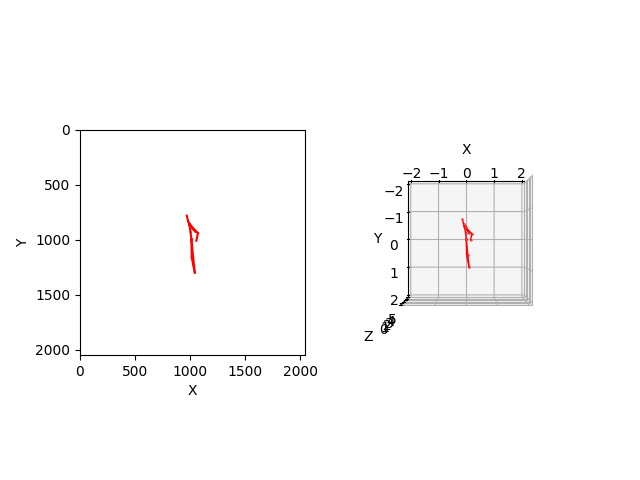

In [4]:
source = 'S1_Seq1_cam5'
subject, seq, cam_num = source.split('_')
#cam_num = cam_num[-1]

R = cam_param[cam_num]['R']
t = cam_param[cam_num]['t']
C = cam_param[cam_num]['C']
W, H = cam_param[cam_num]['W'], cam_param[cam_num]['H']
intrinsic = cam_param[str(cam_num)]['intrinsic']
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]

frame_num = -1
valid_frame = data_dict[source]['valid_frame']
num_valid_frame = data_dict[source]['num_valid_frame']
img_2d_gt = data_dict[source]['annot2'][valid_frame][frame_num]

cam_3d = data_dict[source]['annot3']/1000
cam_3d_hat = get_rootrel_pose(cam_3d)

cam_3d_from_canonical_3d = cam_3d.copy()
cam_3d_from_canonical_3d[...,:2] -= cam_3d[:, 0:1, :2]
cam_3d_from_canonical_3d[..., 2] -= cam_3d[:, 0:1, 2] 
cam_3d_from_canonical_3d[..., 2] += 5
img_2d_from_canonical_3d = np.einsum('ij,jkl->ikl', intrinsic, cam_3d_from_canonical_3d.T).T
img_2d_from_canonical_3d = img_2d_from_canonical_3d / img_2d_from_canonical_3d[..., 2:3]

# box = infer_box(cam_3d[frame_num], {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
# img_2d, img_3d = camera_to_image_frame(cam_3d[frame_num], box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
# img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

# 2.5d factor
#pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat[frame_num], stop_tolerance=0.0001) # x,y,z 사용

fig = plt.figure(3)
fig.clear()
ax = axes_2d(fig, loc=121, H=H, W=W)
ax_cam = axes_3d(fig, loc=122, view=(-90,-90), xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 5))
#draw_2d_pose(ax, img_2d_gt, H=H, W=W)
draw_2d_pose(ax, img_2d_from_canonical_3d[frame_num], H=H, W=W, color='r')

#draw_3d_pose(ax_cam, cam_3d[frame_num])
draw_3d_pose(ax_cam, cam_3d_from_canonical_3d[frame_num], color='r')
plt.show()

In [7]:
cam_3d.shape, cam_3d_from_canonical_3d.shape, img_2d_from_canonical_3d.shape

((6416, 17, 3), (6416, 17, 3), (6416, 17, 3))

### train pkl

In [15]:
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/3dhp_gt_train_canonical_3d_fixed_dist_5_pkl'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    
pass_cam = [] # [0, 1, 2, 4, 5, 6, 7, 8]
cam_params = readpkl(f'/home/{user}/codes/MotionBERT/custom_codes/Dataset_generation/3dhp/3dhp_train_cam_params.pkl')

pbar = tqdm(natsorted(os.listdir(train_folder)))
for subject in pbar:
    for seq in natsorted(os.listdir(os.path.join(train_folder, subject))):
        for cam_num in range(14):
            if len(pass_cam) > 0:
                if cam_num not in pass_cam: continue
            source = '_'.join([subject, seq, f'cam{cam_num}'])
            file_name = source + '.pkl'
            save_path = os.path.join(save_folder, file_name)
            if os.path.exists(save_path):
                print(f'{file_name} already exists')
                continue
            
            data = {}
            for key in ['joint_2d', 'joint_2d_from_canonical_3d', 'confidence', 'joint3d_image', 'camera_name', 'action', 'source', 'frame', 'cam_3d', 'cam_3d_from_canonical_3d', 'cam_param']:
                data[key] = []
                
            cam_param = cam_params[f'cam{cam_num}']
            R = cam_param['R']
            t = cam_param['t']
            C = cam_param['C']
            intrinsic = cam_param['intrinsic']
            fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]
            
            action = source
            camera_id = cam_num

            valid_frame = data_dict[source]['valid_frame']
            num_valid_frame = data_dict[source]['num_valid_frame']
            
            img_2d = data_dict[source]['annot2'][valid_frame]
            cam_3d = data_dict[source]['annot3'][valid_frame]/1000
            # cam_3d_hat = get_rootrel_pose(cam_3d)
            cam_3d_from_canonical_3d = cam_3d.copy()
            cam_3d_from_canonical_3d[...,:2] -= cam_3d[:, 0:1, :2]
            cam_3d_from_canonical_3d[..., 2] -= cam_3d[:, 0:1, 2] 
            cam_3d_from_canonical_3d[..., 2] += 5
            img_2d_from_canonical_3d = np.einsum('ij,jkl->ikl', intrinsic, cam_3d_from_canonical_3d.T).T
            img_2d_from_canonical_3d = img_2d_from_canonical_3d / img_2d_from_canonical_3d[..., 2:3]
            
            # store
            data['joint_2d'] = list(img_2d)
            data['joint_2d_from_canonical_3d'] = list(img_2d_from_canonical_3d)
            data['confidence'] = np.ones_like(img_2d)
            #data['joint3d_image'].append(np.array(img_3d).copy()) 
            #data['joints_2.5d_image'].append(np.array(img_25d).copy()) 
            #data['2.5d_factor'].append(np.array(pred_lambda).copy()) 
            data['camera_name'] = [camera_id] * len(img_2d)
            data['action'] = [action] * len(img_2d)
            data['source'] = [source] * len(img_2d)
            data['frame'] = list(range(len(img_2d)))
            data['cam_3d'] = list(cam_3d)
            data['cam_3d_from_canonical_3d'] = list(cam_3d_from_canonical_3d)
            data['cam_param'] = [cam_param] * len(img_2d)
            #pbar.postfix = f'{source} frame: {frame_num}'

            savepkl(data, save_path)
    #         break
    #     break
    # break
    pbar.postfix = f'{source}'

100%|██████████| 8/8 [00:26<00:00,  3.36s/it, S8_Seq2_cam13]


In [12]:
for key in data.keys():
    print(key, len(data[key]), np.array(data[key]).shape)

joint_2d 4797 (4797, 17, 2)
joint_2d_from_canonical_3d 4797 (4797, 17, 3)
confidence 4797 (4797, 17, 2)
joint3d_image 0 (0,)
camera_name 4797 (4797,)
action 4797 (4797,)
source 4797 (4797,)
frame 4797 (4797,)
cam_3d 4797 (4797, 17, 3)
cam_3d_from_canonical_3d 4797 (4797, 17, 3)
cam_param 4797 (4797,)
